# FloodNet Project

## Imports

In [1]:
import sys
!pip install mlxtend tqdm albumentations torch

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2

from torch import nn
import torch.nn.functional as F

from torch.optim import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score, jaccard_score
from mlxtend.plotting import plot_confusion_matrix

import time

from torch.optim.lr_scheduler import StepLR

In [3]:
#if mean and standard deviation for training sample should be recomputed
RECOMPUTE_MEAN_STD = False

#choose the device cuda if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Dataset

In [5]:
class FloodData(Dataset):

    #map between label class names and indices
    LABEL_CLASSES = {
      'background': 		  0,
      'building-flooded': 			    1,
      'building-non-flooded': 	  2,
      'road-flooded': 				      3,
      'road-non-flooded': 			    4,
      'water': 			    5,
      'tree':   6,
      'vehicle': 				    7,
      'pool': 				    8,
      'grass': 			  9
    }
    
    #initialize the dataset
    def __init__(self, transforms=None, split='train'):
        
        self.transforms = transforms
        
        #load image/mask names and store them in SPLIT
        SPLIT = pd.read_csv("FloodNet_split_train_valid_test.csv", sep=',', header=None, names=["Column1", "Column2", "Column3"])
        SPLIT["Column1"] = SPLIT["Column1"].map(lambda x: "data/image/" + x)
        SPLIT["Column2"] = SPLIT["Column2"].map(lambda x: "data/mask/" + x)
        
        #take the set corresponding to the given split (train, validation or test)
        splitted_set = SPLIT[SPLIT["Column3"]==split]
        
        #prepare data (list of tuples of (image path, label class))
        self.data = list(zip(splitted_set["Column1"], splitted_set["Column2"]))
    
    #give the length of the dataset
    def __len__(self):
        return len(self.data)

    #give the transformed image and mask
    def __getitem__(self, x):
        #get the image and mask names
        imgName, labelsName = self.data[x]

        #load pixel values and apply transforms
        img = np.array(Image.open(imgName))
        labels = np.array(Image.open(labelsName))
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=labels)
            img = transformed['image']
            labels = transformed['mask']
        else:
            img, labels = img[:3000, :4000,:], labels[:3000, :4000]
        img, labels = torch.tensor(img).float(), torch.tensor(labels).long()
        
        #move band dimension to the first dimension, because it is expected like this in the model
        img = torch.movedim(img, 2, 0)

        return img, labels

In [6]:
#compute the mean and standard deviation of all pixels of images from a DataLoader
#source : https://www.binarystudy.com/2021/04/how-to-calculate-mean-standard-deviation-images-pytorch.html
def batch_mean_and_sd(loader):
    count = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)
    
    for images, _  in tqdm(loader):
        b, c, h, w = images.shape #batch, color, height, width
        nb_pixels = b*h*w
        
        sum_ = torch.sum(images, dim = [0,2,3])
        sum_of_square = torch.sum(torch.square(images), dim = [0,2,3])
        
        fst_moment = (count*fst_moment+sum_)/(count+nb_pixels)
        snd_moment = (count*snd_moment+sum_of_square)/(count+nb_pixels)

        count += nb_pixels
        
    mean, std = fst_moment, torch.sqrt(snd_moment-fst_moment**2)
    return mean, std

#recompute the mean and standard deviation if RECOMPUTE_MEAN_STD = True
if RECOMPUTE_MEAN_STD:
    train_not_transformed_set = FloodData(transforms = None, split = 'train')
    train_not_transformed_loader = DataLoader(train_not_transformed_set, batch_size = 4)
    mean, std = batch_mean_and_sd(train_not_transformed_loader)
    print(mean, std)
else:
    mean, std = [106.5385, 116.1601,  87.6059], [53.1837, 49.5205, 53.5828]

In [7]:
#definitions of the transforms used for training and validation data respectively
transform_train = A.Compose([
    A.RandomSizedCrop(min_max_height = [1000, 2500], height=713, width=713),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.5),
    A.Blur(blur_limit = 3),
    A.RandomRotate90(),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

transform_val = A.Compose([
    A.RandomSizedCrop(min_max_height = [1000, 2500], height=713, width=713),
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

In [8]:
#create train and validation sets
train_dataset = FloodData(transforms = transform_train, split = 'train')
val_dataset = FloodData(transforms = transform_val, split = 'valid')

## Models

### Resnet model

In [9]:
#class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [10]:
#function and class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            
        #on a décalé
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 64) #128)
        self.bn3 = nn.BatchNorm2d(64) #128)
            
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    # for the PSPNet, this forward is never used. We will still leave it for completion
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### PPM model

In [11]:
#class used for PSPNet
#source : https://github.com/hszhao/semseg/tree/master/model
class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        #print("PPM size of x:", x_size)
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

### PSPNet model

In [12]:
#main source : https://github.com/hszhao/semseg/tree/master/model
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=10, zoom_factor=8, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        #set parameters
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.criterion = criterion    
        
        #load Resnet model from 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth'
        path_to_pretrained = "./resnet101.pth"
        resnet = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=1000, deep_base=False)
        resnet.load_state_dict(torch.load(path_to_pretrained), strict=False)

        #create first layers, taken from Resnet
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        #change parameters for layers 3 and 4
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
        #feature dimension after Resnet
        fea_dim = 2048
        
        #create the pyramid pooling module
        self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
        fea_dim *= 2
        
        #create the last layers
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )


    def forward(self, x, y=None):
        #set size parameters
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        #apply PSPNet layers
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        #if training mode, compute the loss
        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

## Useful functions for training and validation steps

### Train functions

In [13]:
#compute the poly-learning rate
#source : https://github.com/hszhao/semseg/blob/4f274c3f276778228bc14a4565822d46359f0cc8/util/util.py#L34
def poly_learning_rate(base_lr, curr_iter, max_iter, power=0.9):
    """poly learning rate policy"""
    lr = base_lr * (1 - float(curr_iter) / max_iter) ** power
    #lr = base_lr *exp(-curr_iter)
    return lr

In [14]:
#compute one training step for one batch
def training_step(batch, model, optimizer, aux_weight, device="cuda"):

    start = time.perf_counter()
    
    #set the model to training mode and initialize gradients
    model.train()
    optimizer.zero_grad()
    model.zero_grad()
    
    #retrieve image and label from the batch
    x, y = batch

    #move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    #forward pass
    y_hat, main_loss, aux_loss = model(x, y)
    
    #loss calculation
    loss = main_loss + aux_weight * aux_loss
    loss = torch.mean(loss)
    
    #backpropagation and model update
    loss.backward()
    optimizer.step()

    #compute the loss
    prediction = y_hat.cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    loss = loss.cpu().detach().numpy()

    #compute the accuracy (mean of correct (1) and incorrect (0) classifications)
    accuracy = (prediction == ground_truth).mean()
    #compute the balanced accuracy
    bal_accuracy = balanced_accuracy_score(y_true=np.concatenate(np.concatenate(ground_truth)), y_pred=np.concatenate(np.concatenate(prediction)))
    
    end = time.perf_counter()
    
    return loss, accuracy, bal_accuracy, prediction, ground_truth

In [15]:
#compute one training epoch for a dataloader
def train_epoch(train_dl, model, optimizer, aux_weight, epoch, max_iter, device, lr, power, break_point=20):

    #to collect statistics
    losses, accuracies, bal_accuracies, predictions, ground_truths  = [], [], [], [], []
    i=1
    
    #do a training step for each batch
    for batch in train_dl:

        #change learning rate
        if power > 0:
            current_iter = epoch * len(train_dl) + i
            current_lr = poly_learning_rate(lr, current_iter, max_iter, power)
            optimizer.param_groups[0]['lr'] = current_lr

        #call training_step
        loss, accuracy, bal_accuracy, prediction, ground_truth = training_step(batch, model, optimizer, aux_weight, 
                                                                               device = device)
        #append statistics
        losses.append(loss)
        accuracies.append(accuracy)
        bal_accuracies.append(bal_accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)
        
        i+=1

    #return averaged losses and accuracies
    return np.stack(losses).mean(), np.stack(accuracies).mean(), np.stack(bal_accuracies).mean(),\
                    np.hstack(predictions), np.hstack(ground_truths)

### Validation functions

In [16]:
#skip the calculation of the gradient graph here to save time
@torch.no_grad() 

#compute predictions on the given batch
def prediction_step(batch, model, criterion, device="cuda"):
    #evaluation mode
    model.eval()
    
    #retrieve image and label from the batch
    x, y = batch
    
    #move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    #forward pass
    y_hat = model(x)
    
    #loss calculation (only for statistics)
    loss = criterion(y_hat, y)
    
    #compute the accuracy for statistics
    predictions = y_hat.argmax(1).cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    loss = loss.cpu().detach().numpy()
    accuracy = (predictions == ground_truth).mean()
    
    return loss, accuracy, predictions, ground_truth

In [17]:
#compute predictions and performances for the given dataloader
def validation(dataloader, model, criterion, breaking_point=10, returning="all", device="cuda"):
    #to store statisticss
    losses, accuracies, predictions, ground_truths = [], [], [], []
    
    #compute a prediction step for each batch
    for batch in dataloader:
        #call prediction_step
        loss, accuracy, prediction, ground_truth = prediction_step(batch, model, criterion, device)

        #append to stats
        losses.append(loss)
        accuracies.append(accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)

    #average val losses and accuracies over batches
    losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
    
    #compute balanced accuracy and Intersection over Union (IoU)
    predictions, ground_truths = np.vstack(predictions), np.vstack(ground_truths)
    val_pred_new = np.concatenate(np.concatenate(predictions))
    val_ground_truth_new = np.concatenate(np.concatenate(ground_truths))
    bal_acc = balanced_accuracy_score(y_true=val_ground_truth_new, y_pred=val_pred_new)
    IoU = jaccard_score(y_true=val_ground_truth_new, y_pred=val_pred_new, average=None)
    
    #print statistics
    print(f"valloss {losses:.2f}, val accuracy {accuracies*100:.2f}, balanced accuracy {bal_acc*100:.2f},\nIntersection over Union:\n{IoU}")
    
    #choose what you want to return
    if returning=="stats":
        return losses, accuracies, bal_acc, IoU
    elif returning=="predictions":
        return predictions, ground_truths
    else:
        return predictions, ground_truths, losses, accuracies, bal_acc, IoU

## Training and validation steps

In [22]:
#parameters for the training step
learning_rate = 0.001 
weight_decay = 0.0001
momentum = 0.9
power=0.9
num_epochs = 30
batch_size = 6
aux_weight = 0.4
break_point= 20
#give higher weights to classes which are more important: 
# building-flooded'(1),'building-non-flooded'(2), 'road-flooded'(3), 'road-non-flooded'(4), 'water'(5)
class_weights=torch.tensor([0.05, 0.2, 0.2, 0.15, 0.15, 0.05, 0.05, 0.05, 0.05, 0.05]).float()
#class_weights=torch.tensor([0.05, 0.25, 0.25, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05]).float()
#class_weights=torch.tensor([0.00001, 0.3, 0.3, 0.14, 0.14, 0.05, 0.00001, 0.03, 0.03997, 0.00001]).float()
#class_weights=torch.tensor(np.ones(10)/10).float() #same weight for all classes

#initialization for the model : use a cross entropy loss, PSPNet and a stochastic gradient descent method to update the weights
criterion=nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
model = PSPNet(criterion=criterion)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

#make parallelization of data if cuda
if torch.cuda.is_available():
    model= nn.DataParallel(model)
    gpus = torch.cuda.device_count()
    batch_size = batch_size*gpus
    print("Number of available GPUS:", gpus, "batch size:", batch_size)

Number of available GPUS: 2 batch size: 12


In [23]:
#put data into Dataloader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [24]:
#this code is used to remove warnings, otherwise accuracy computations for validation warns that model predicts labels which are not in ground truth
#(due to the small validation sample size)
import warnings
warnings.filterwarnings('ignore') 

In [25]:
#do the training, and the validation every 5 epochs
stats = []
for epoch in range(num_epochs):
    
    start = time.perf_counter()
    
    #call train_epoch
    train_loss, train_accuracy, train_bal_accuracy, train_pred, train_ground_truth = train_epoch(train_loader, 
                                model, optimizer, aux_weight, epoch=epoch, max_iter=num_epochs*len(train_loader), 
                                device=DEVICE, lr=learning_rate, power=power, break_point=break_point)
    
    end = time.perf_counter()
    
    print(f"epoch {epoch+1}; trainloss {train_loss:.2f}, train accuracy {train_accuracy*100:.2f}%,\
    train balanced accuracy {train_bal_accuracy*100:.2f}%")
   
    #compute validation
    if epoch % 5 == 0 or epoch==(num_epochs-1):
        val_predictions, val_ground_truths, val_losses, val_accuracies, val_bal_acc, val_IoU = validation(val_dl, model, criterion,  breaking_point=2, device=DEVICE)
    print("time for one epoch :", end - start)
    
    #store statistics
    stats.append({
        "trainloss":float(train_loss),
        "trainaccuracy":float(train_accuracy),
        "train_balanced_acc":float(train_bal_accuracy),
        "valloss":float(val_losses),
        "valaccuracy":float(val_accuracies),
        "val_balanced_acc":float(val_bal_acc),
        "epoch":epoch
    })

0.0009699493779682662
epoch 1; trainloss 2.41, train accuracy 51.20%,    train balanced accuracy 32.38%
valloss 1.11, val accuracy 65.75, balanced accuracy 28.19,
Intersection over Union:
[0.         0.04809636 0.24842441 0.00199241 0.38368672 0.46969211
 0.11832927 0.         0.         0.66652064]
time for one epoch : 167.01997509039938
0.0009397949325887223
epoch 2; trainloss 1.60, train accuracy 70.60%,    train balanced accuracy 44.33%
time for one epoch : 193.59571155160666
0.0009095325760829623
epoch 3; trainloss 1.36, train accuracy 73.79%,    train balanced accuracy 47.94%
time for one epoch : 190.83092382736504
0.0008791579019367991
epoch 4; trainloss 1.30, train accuracy 73.82%,    train balanced accuracy 48.04%
time for one epoch : 193.32872650399804
0.0008486661467891869
epoch 5; trainloss 1.26, train accuracy 75.97%,    train balanced accuracy 48.09%
time for one epoch : 189.7142154276371
0.0008180521460508585
epoch 6; trainloss 1.20, train accuracy 75.65%,    train balan

In [26]:
#save the model into the file model_param.pth
torch.save(model, "model_param.pth")

## Statistics for training and validation steps

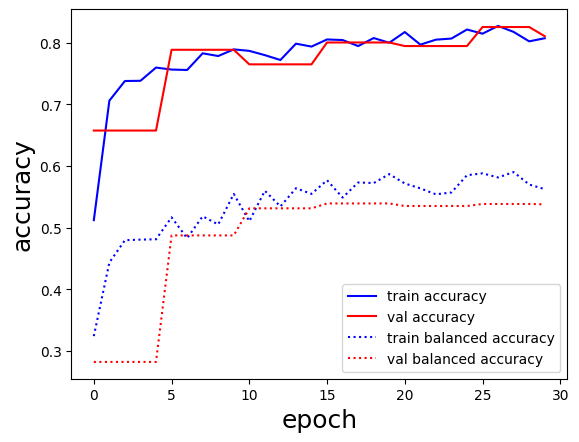

In [36]:
#accuracy
train_losses = np.stack([stat["trainloss"] for stat in stats])
train_accuracy = np.stack([stat["trainaccuracy"] for stat in stats])
train_bal_accuracy = np.stack([stat["train_balanced_acc"] for stat in stats])
val_losses = np.stack([stat["valloss"] for stat in stats])
val_accuracy = np.stack([stat["valaccuracy"] for stat in stats])
val_bal_accuracy = np.stack([stat["val_balanced_acc"] for stat in stats])
epoch = np.stack([stat["epoch"] for stat in stats])

fig, ax = plt.subplots()
ax.plot(epoch, train_accuracy, label="train accuracy", color = 'b')
ax.plot(epoch, val_accuracy, label="val accuracy", color = 'r')
ax.plot(epoch, train_bal_accuracy, label="train balanced accuracy", color = 'b', linestyle="dotted")
ax.plot(epoch, val_bal_accuracy, label="val balanced accuracy", color = 'r', linestyle="dotted")
ax.legend()
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("accuracy", fontsize=18)
fig.savefig('accuracy'+'.pdf', format='pdf', bbox_inches = 'tight')

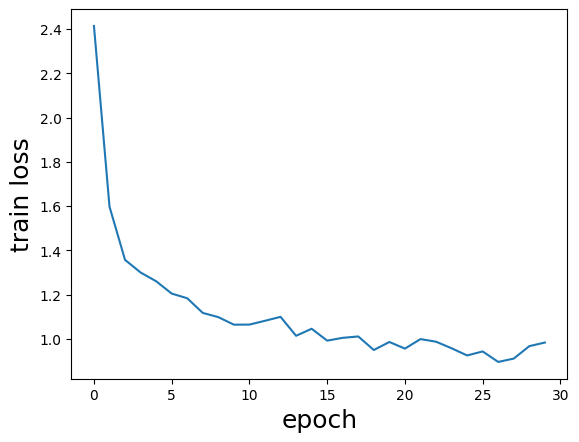

In [33]:
#loss for training data only
fig, ax = plt.subplots()
ax.plot(epoch, train_losses)
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("train loss", fontsize=18)
fig.savefig('train_loss'+'.pdf', format='pdf', bbox_inches = 'tight')

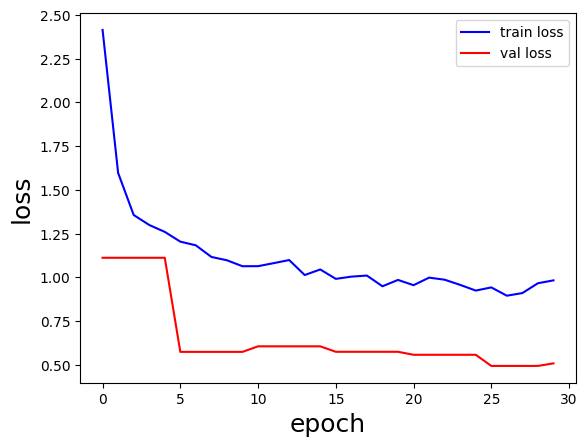

In [34]:
#loss
fig, ax = plt.subplots()
ax.plot(epoch, train_losses, label="train loss", color = 'b')
ax.plot(epoch, val_losses, label="val loss", color = 'r')
ax.legend()
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("loss", fontsize=18)
fig.savefig('loss'+'.pdf', format='pdf', bbox_inches = 'tight')

In [37]:
#compute and print the confusion éatrix
def print_confusion_matrix(prediction, ground_truth, save_name='train_confusion_matrix'):
    labels_in_data = []
    for key in FloodData.LABEL_CLASSES.keys():
        if FloodData.LABEL_CLASSES[key] in ground_truth:
            labels_in_data.append(key)

    cm = confusion_matrix(y_true=ground_truth, y_pred=prediction)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(10,10), cmap="Blues", class_names=labels_in_data)
    plt.xlabel('Predicted label', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    fig.savefig(save_name+'.pdf', format='pdf', bbox_inches = 'tight')

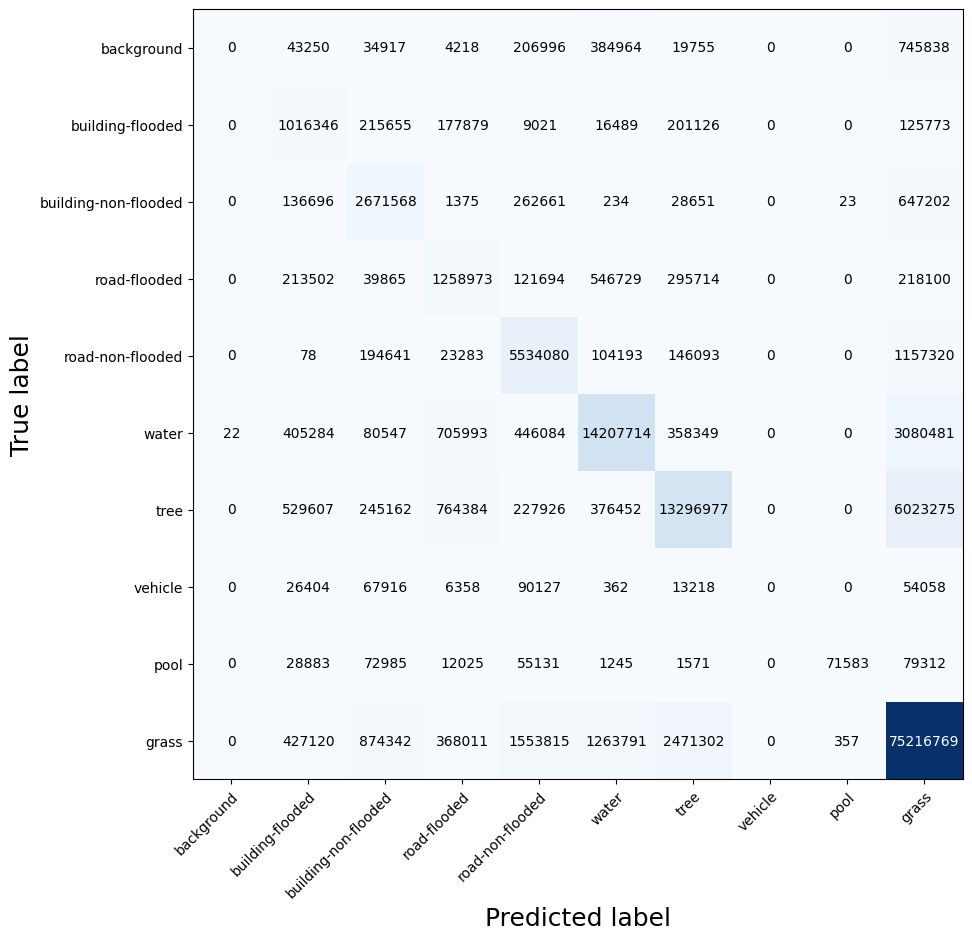

In [38]:
#confusion matrix for training
train_pred_new = np.concatenate(np.concatenate(train_pred))
train_ground_truth_new = np.concatenate(np.concatenate(train_ground_truth))

print_confusion_matrix(train_pred_new, train_ground_truth_new)

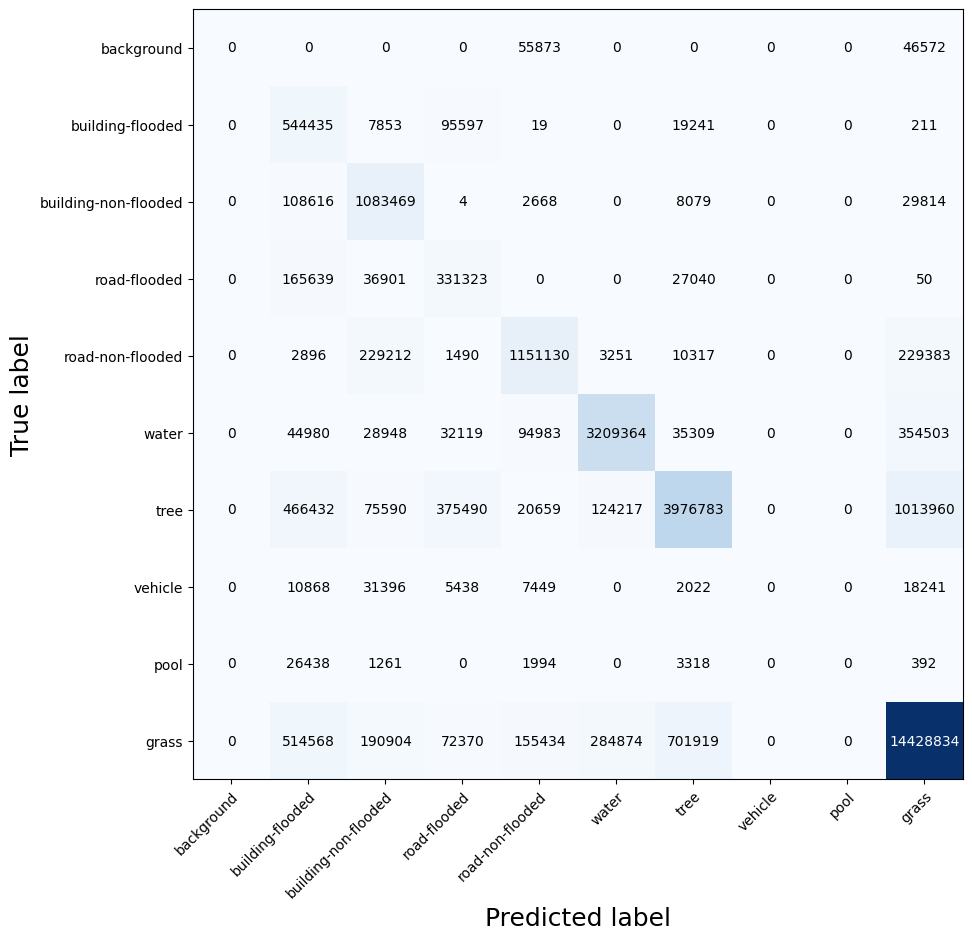

In [39]:
#confusion matrix for validation
val_pred_new = np.concatenate(np.concatenate(val_predictions))
val_ground_truth_new = np.concatenate(np.concatenate(val_ground_truths))

print_confusion_matrix(val_pred_new, val_ground_truth_new, save_name='validation_confusion_matrix')

## Visualization for validation set

In [40]:
#functions to display predictions
def get_label_image(label_map):
    colors = np.array([[0, 0, 0], # Background: black
                       [255, 51, 51],  # Building flooded: orange
                       [179, 81, 77],  # Building non-flooded: brown
                       [161, 161, 0],  # Road flooded: dark green
                       [153, 153, 153],  # Road non-flooded
                       [0, 255, 255],  # Water: turquoise
                       [51, 51, 255],  # Tree: blue
                       [255, 102, 255],  # Vehicle: pink
                       [255, 0, 0], # Pool: red
                       [51, 255, 51]])  # Grass: green  
    colors = colors.astype(np.uint8)
    color_map = np.zeros((label_map.shape[0], label_map.shape[1], 3)).astype(np.uint8)
    for label_id in range(colors.shape[0]):
        color_map[label_map == label_id] = colors[label_id, :]
    return color_map


def display_all(ground_truth, predictions, image_nr):   
    f, ax = plt.subplots(1,2, figsize=(8, 8))
    
    ax[0].imshow(get_label_image(ground_truth[image_nr]))
    ax[0].set_title('True labels')
    
    ax[1].imshow(get_label_image(predictions[image_nr]))
    ax[1].set_title('Predicted labels')
    
    plt.show()
    save_name = "pred"
    f.savefig("Results/"+save_name+str(image_nr)+'.pdf', format='pdf', bbox_inches = 'tight')

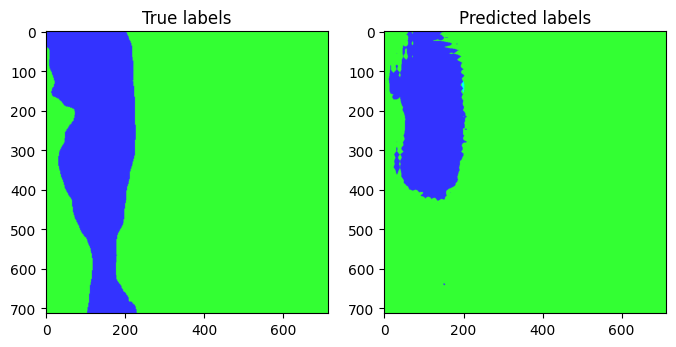

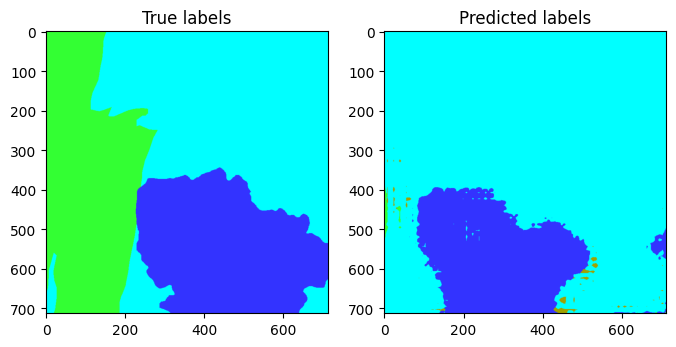

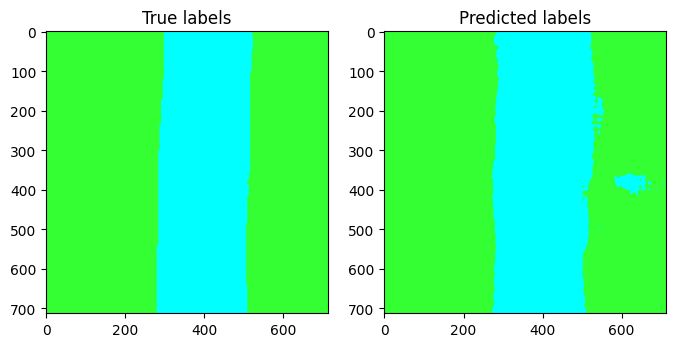

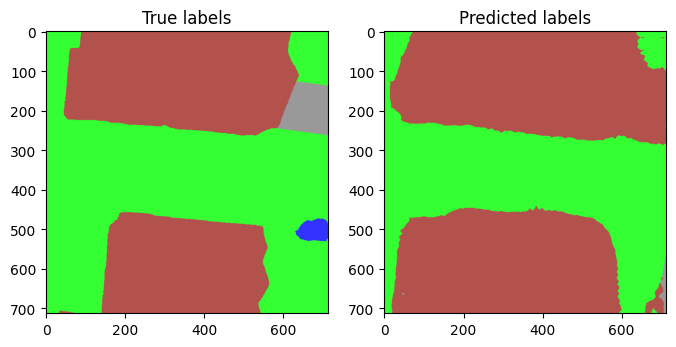

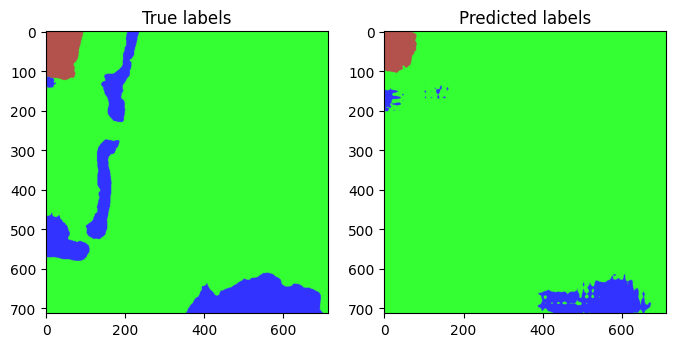

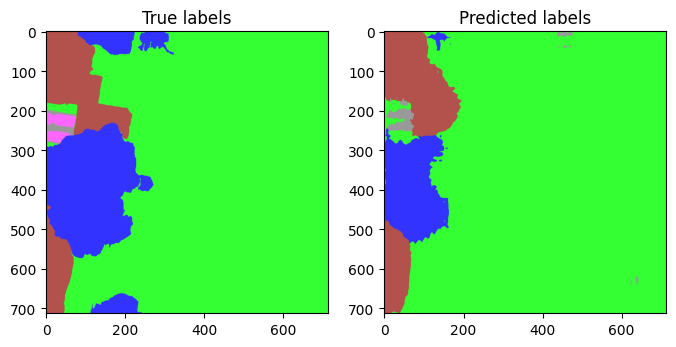

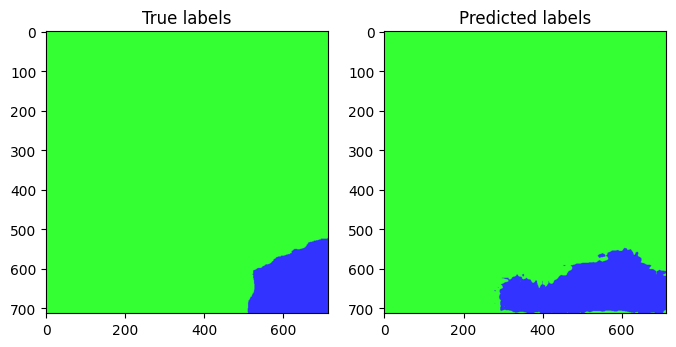

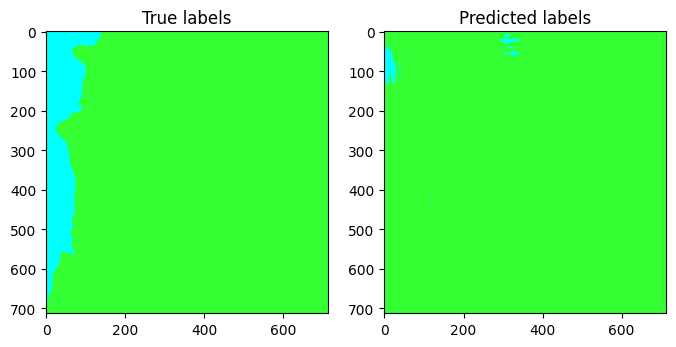

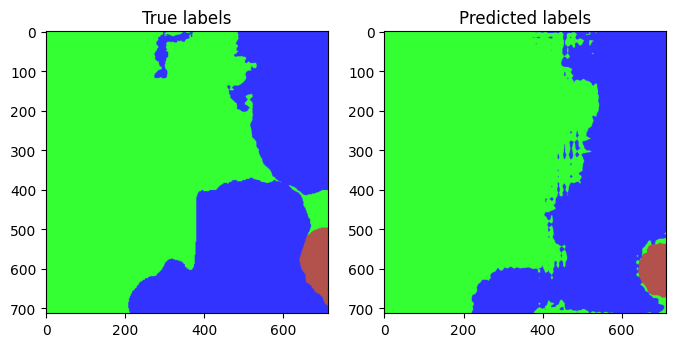

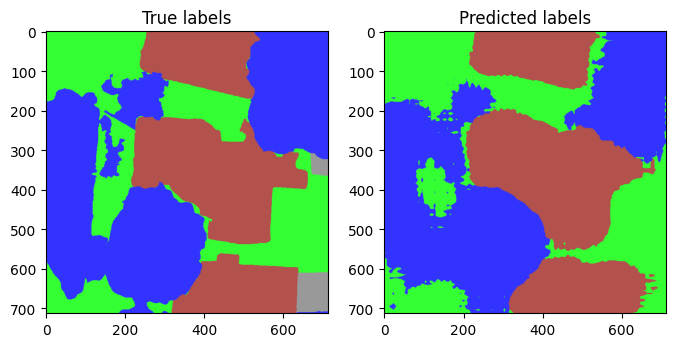

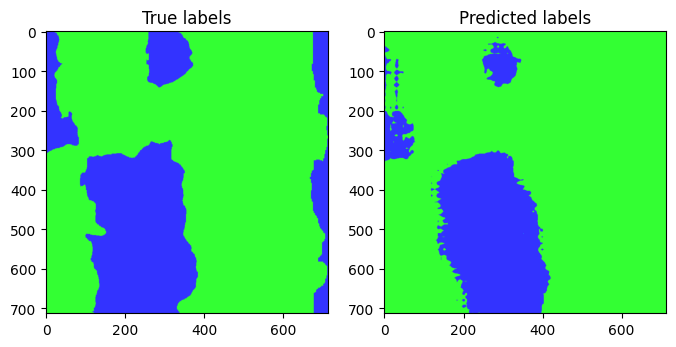

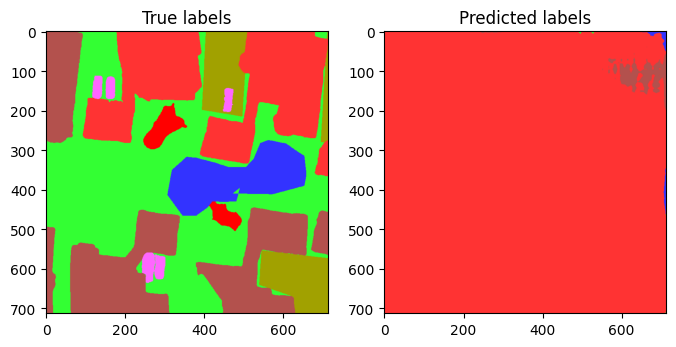

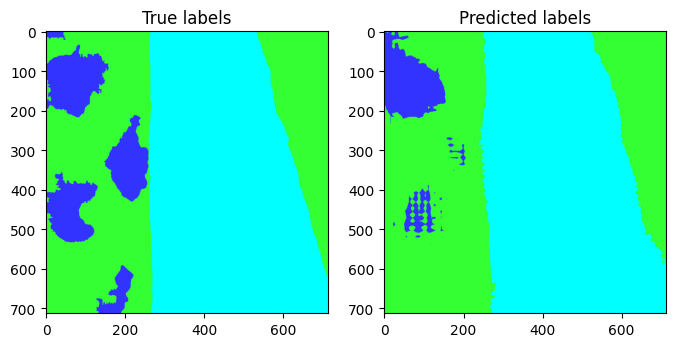

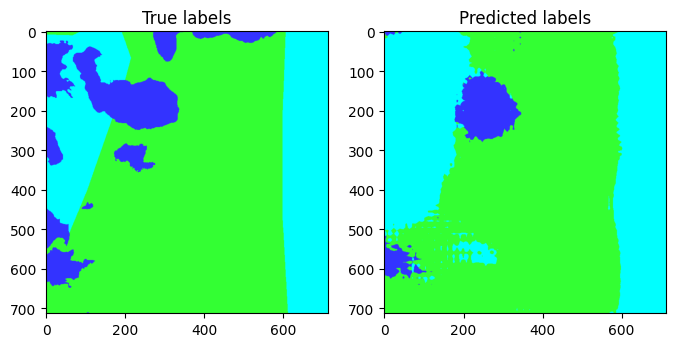

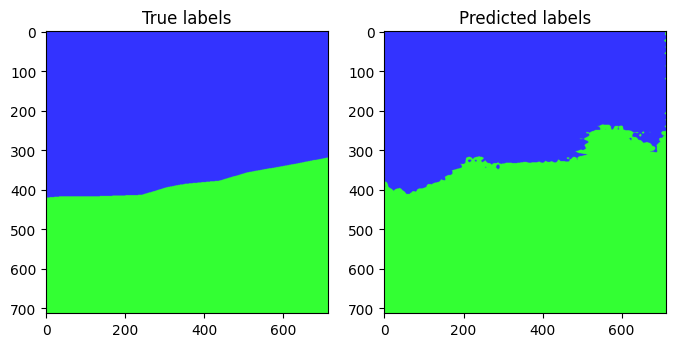

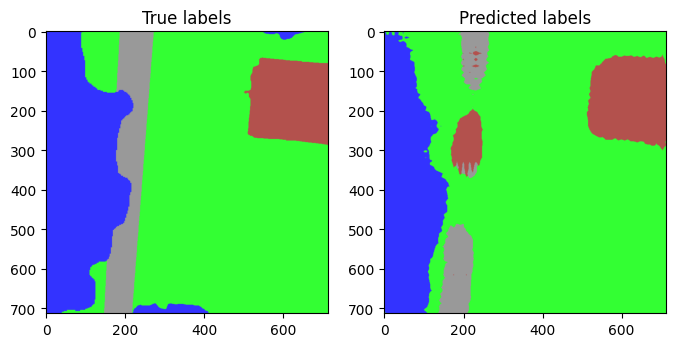

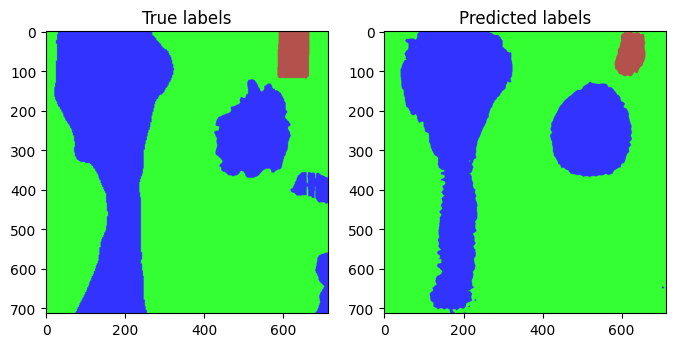

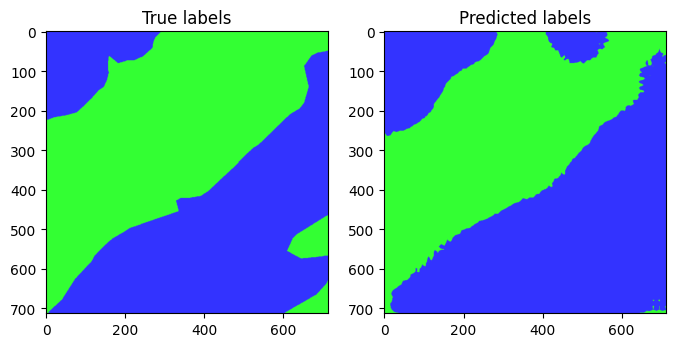

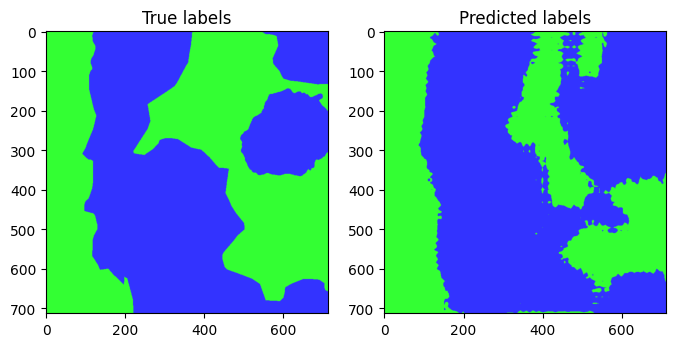

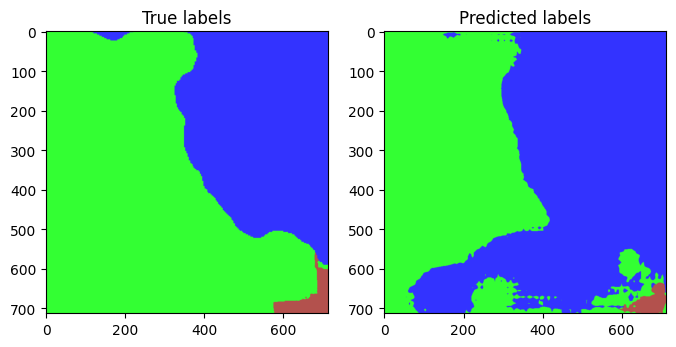

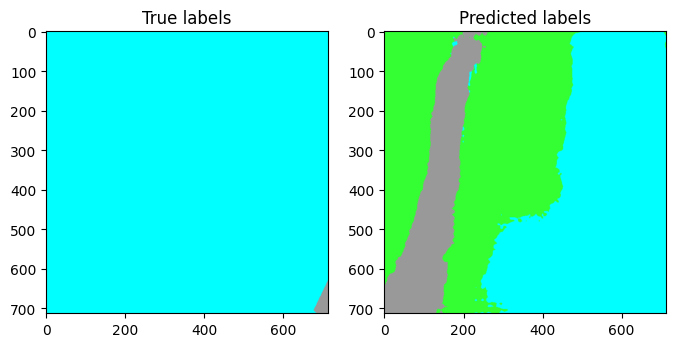

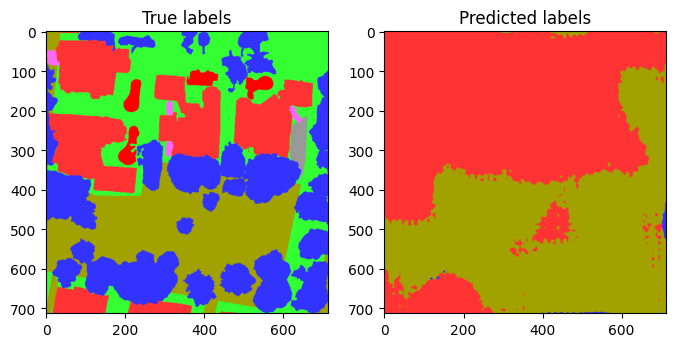

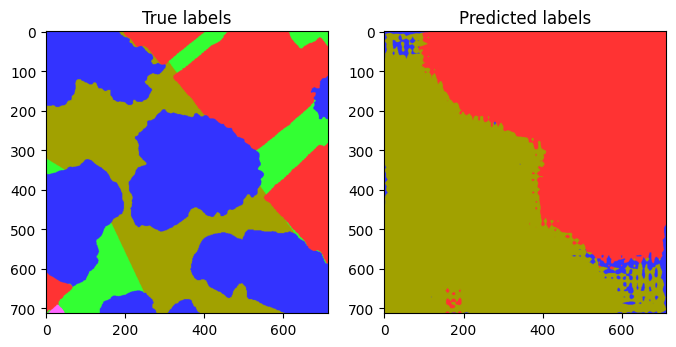

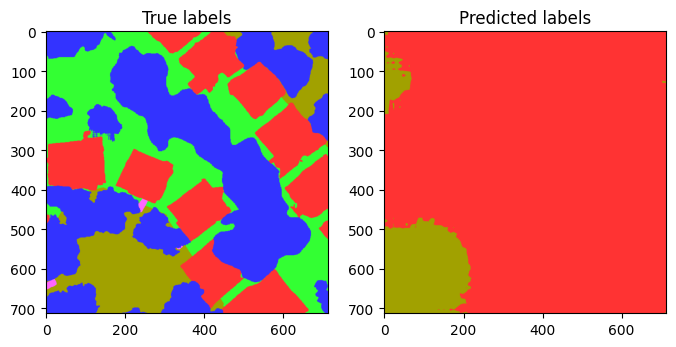

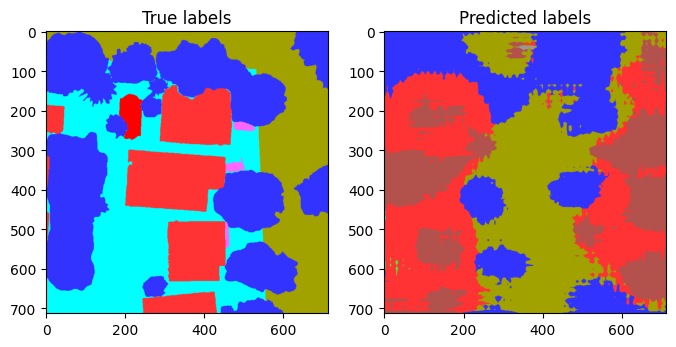

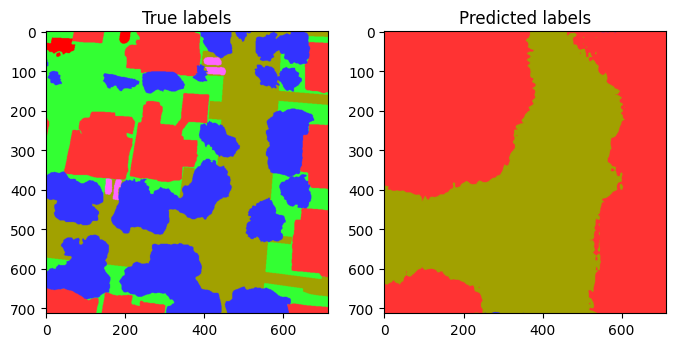

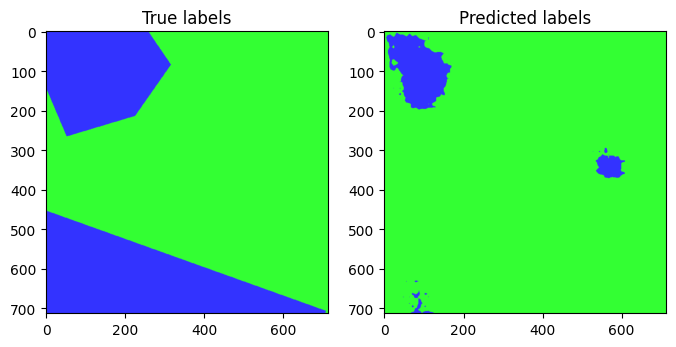

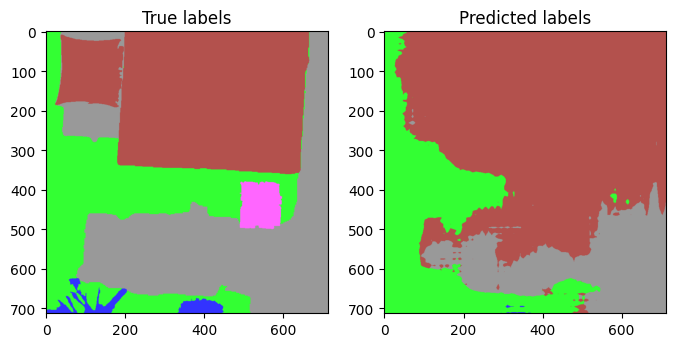

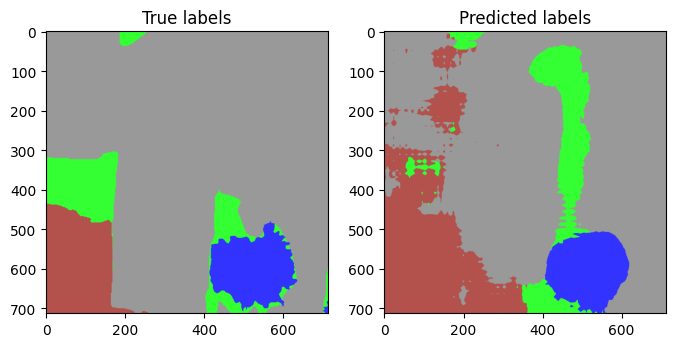

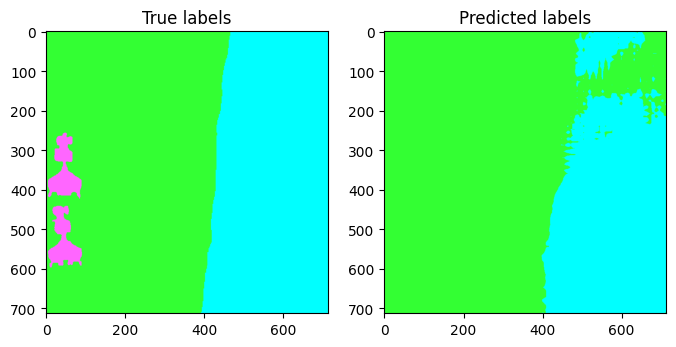

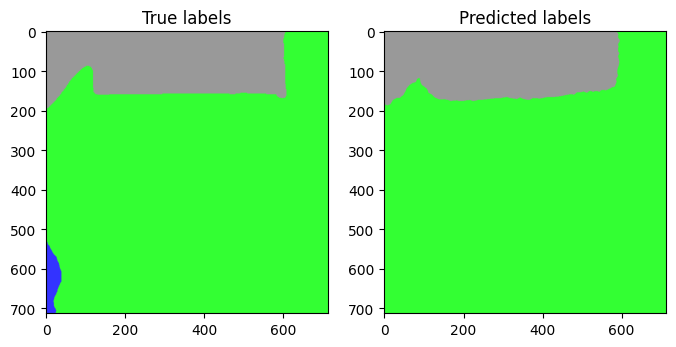

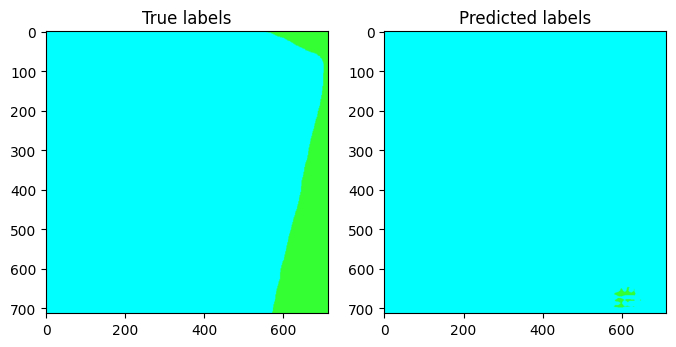

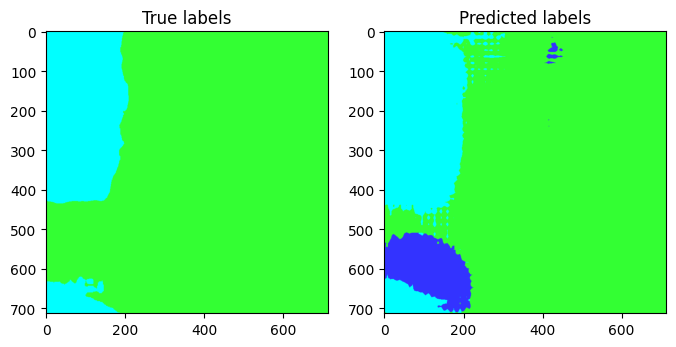

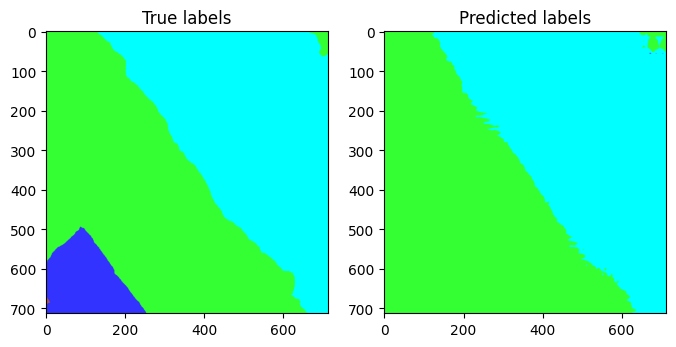

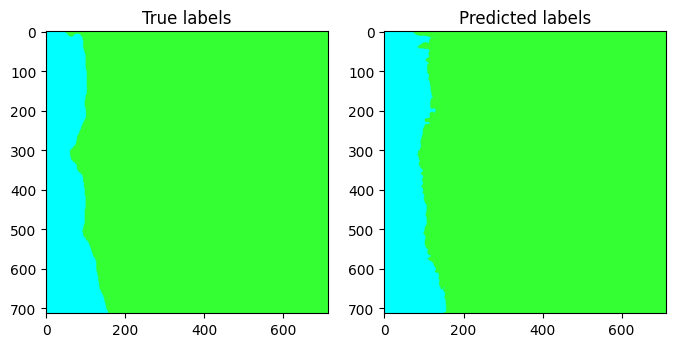

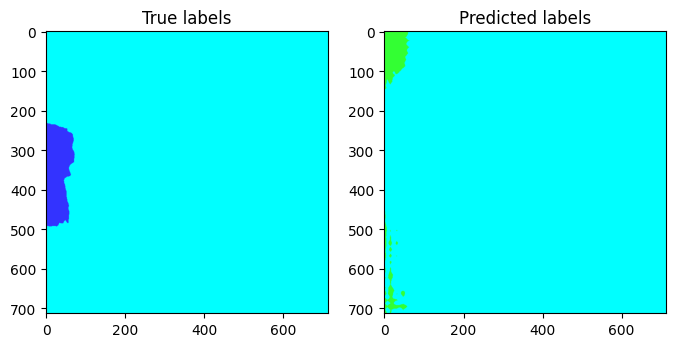

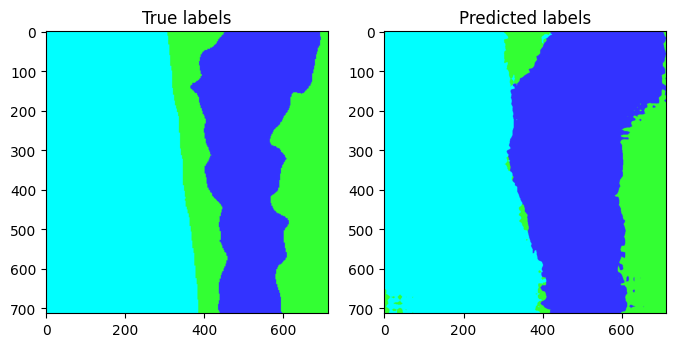

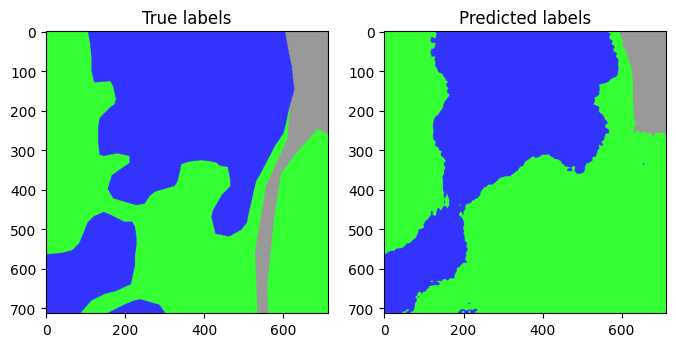

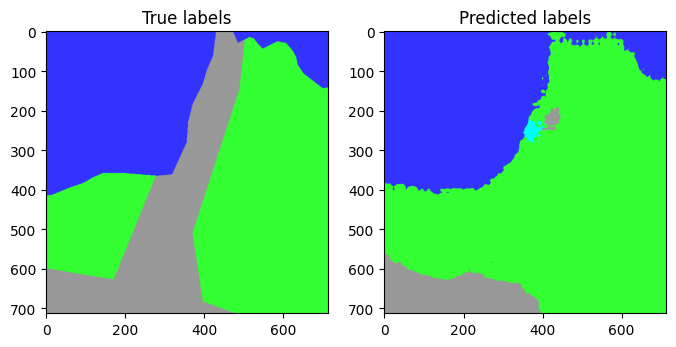

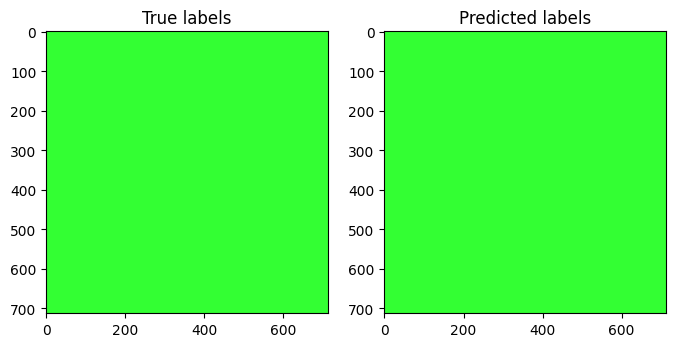

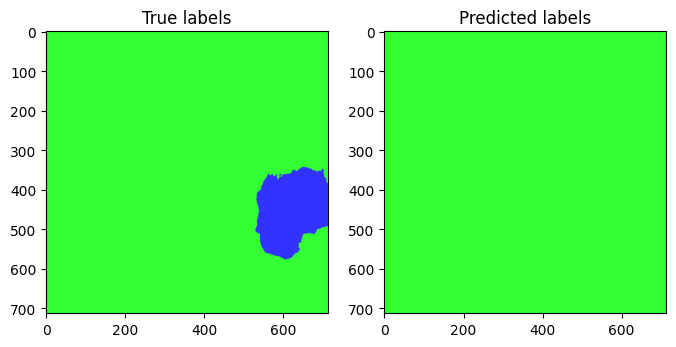

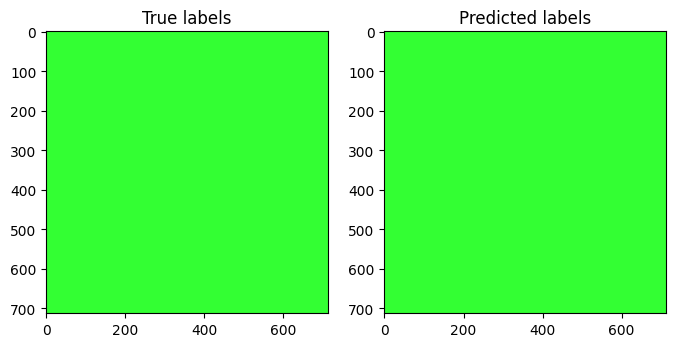

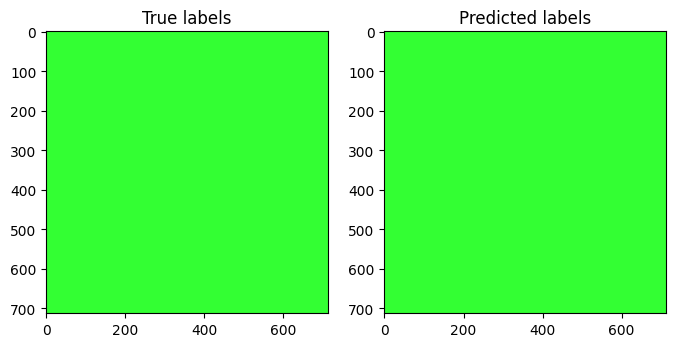

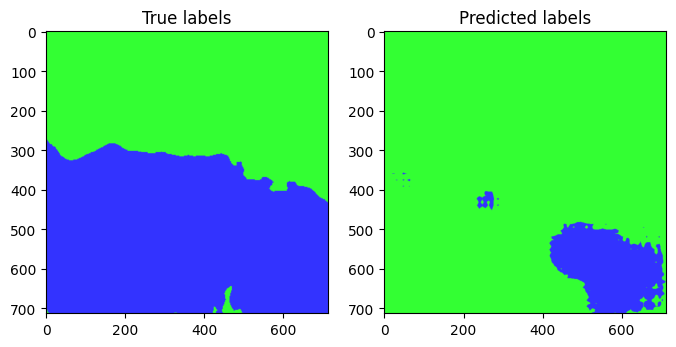

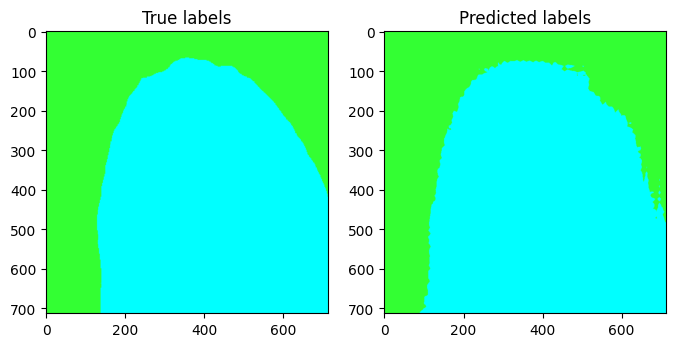

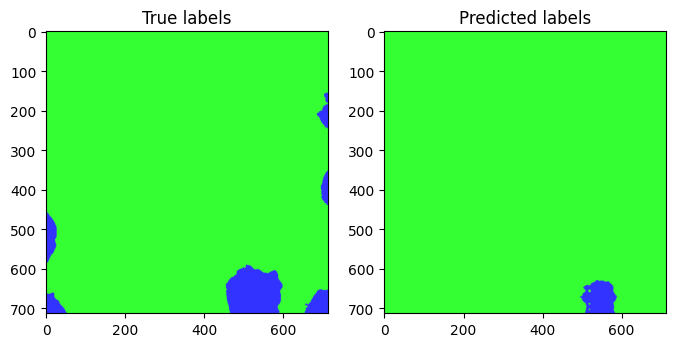

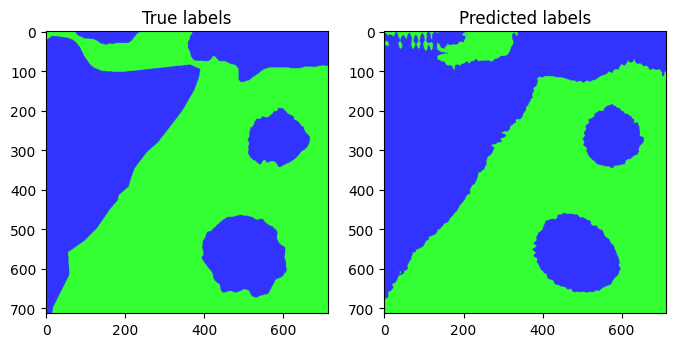

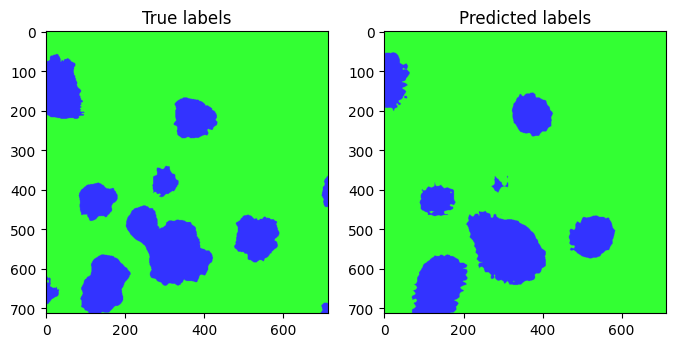

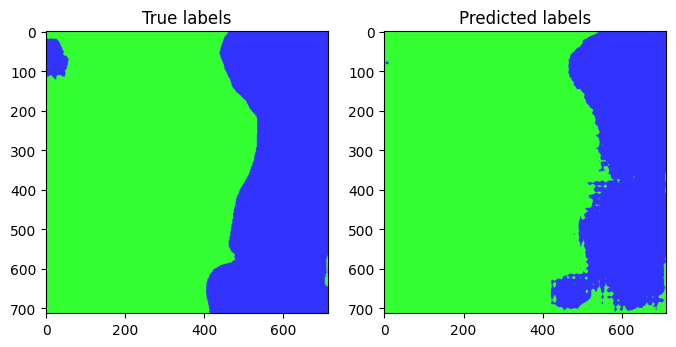

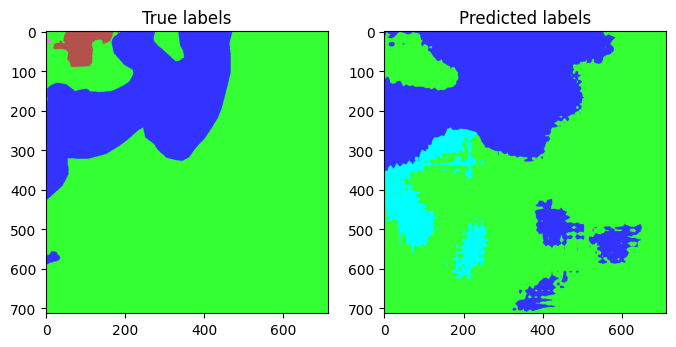

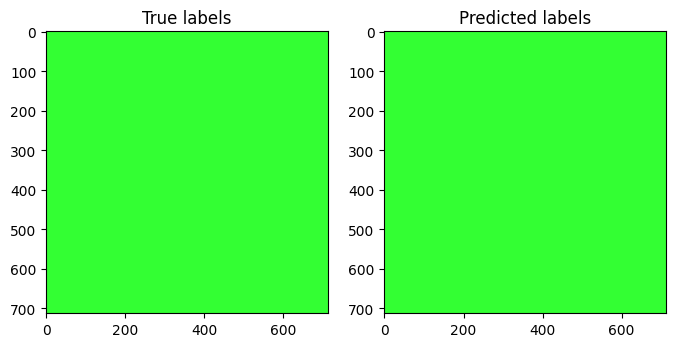

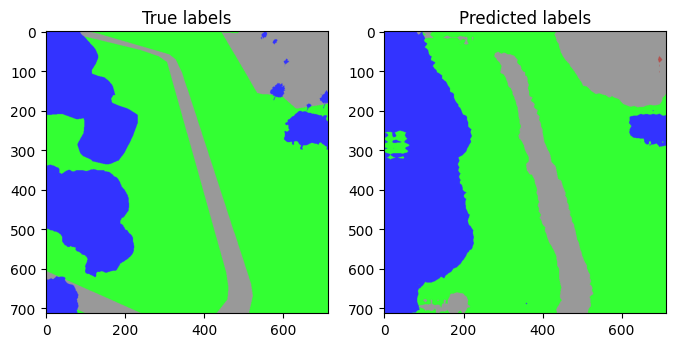

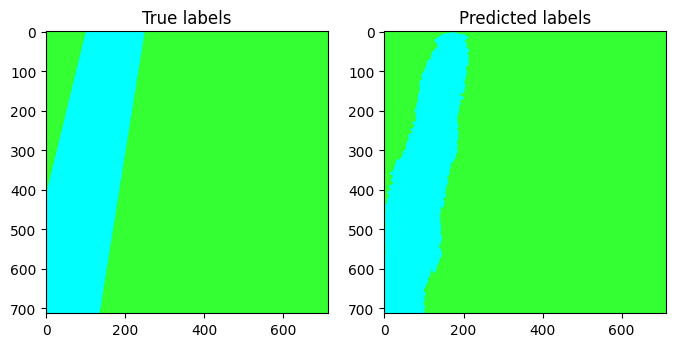

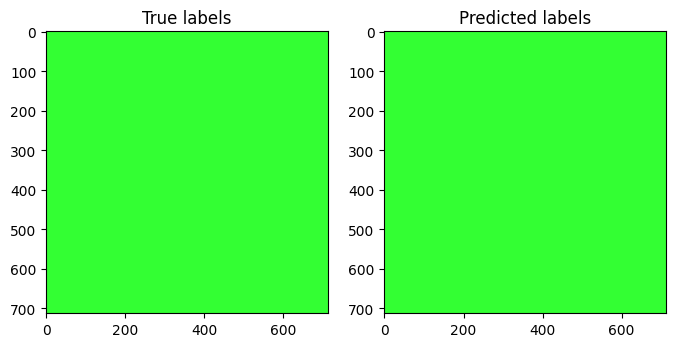

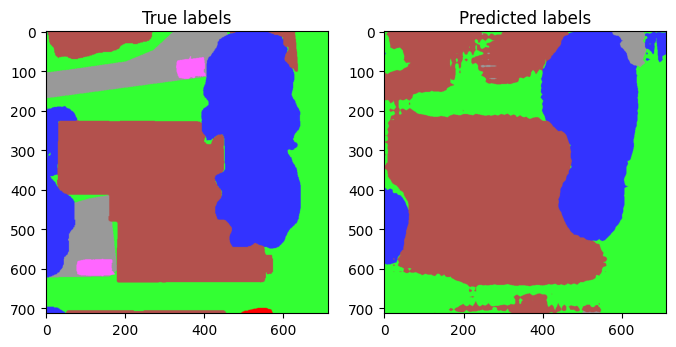

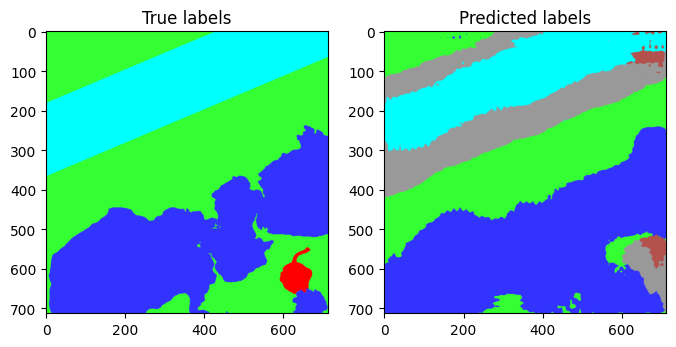

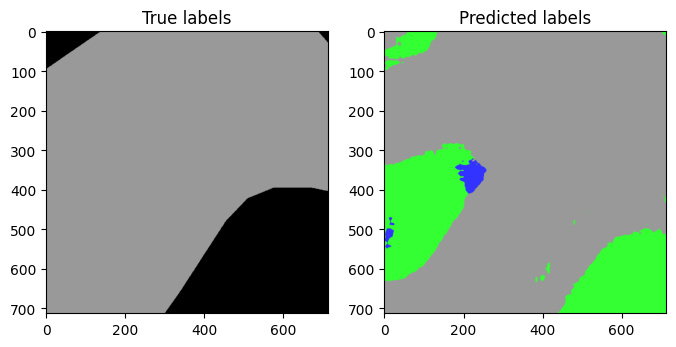

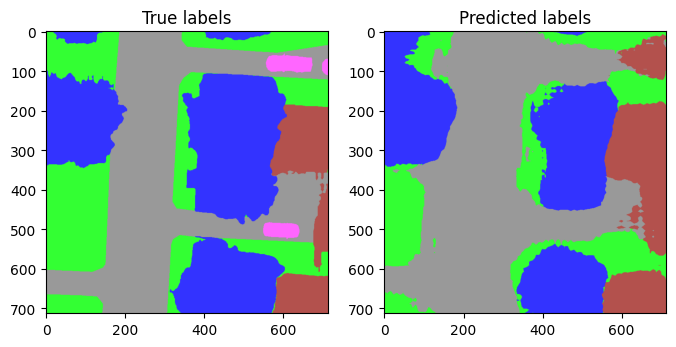

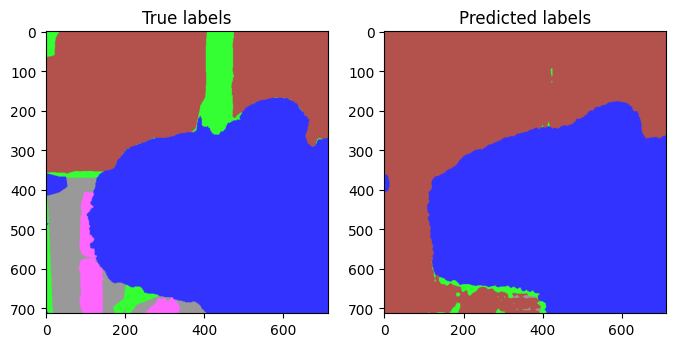

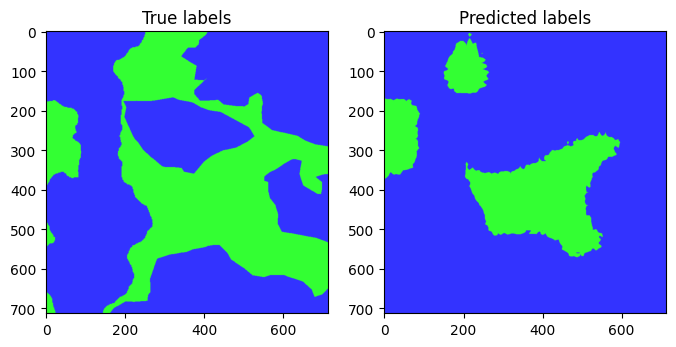

In [41]:
#display predictions on the validation dataset
for i in range(60):
    display_all(val_ground_truths, val_predictions, i)